# 1.Preset

## 1.1 Read image, set bits occupied by "Run-Length", use RGB-to-YCbCr or not and block size.

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['qr']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


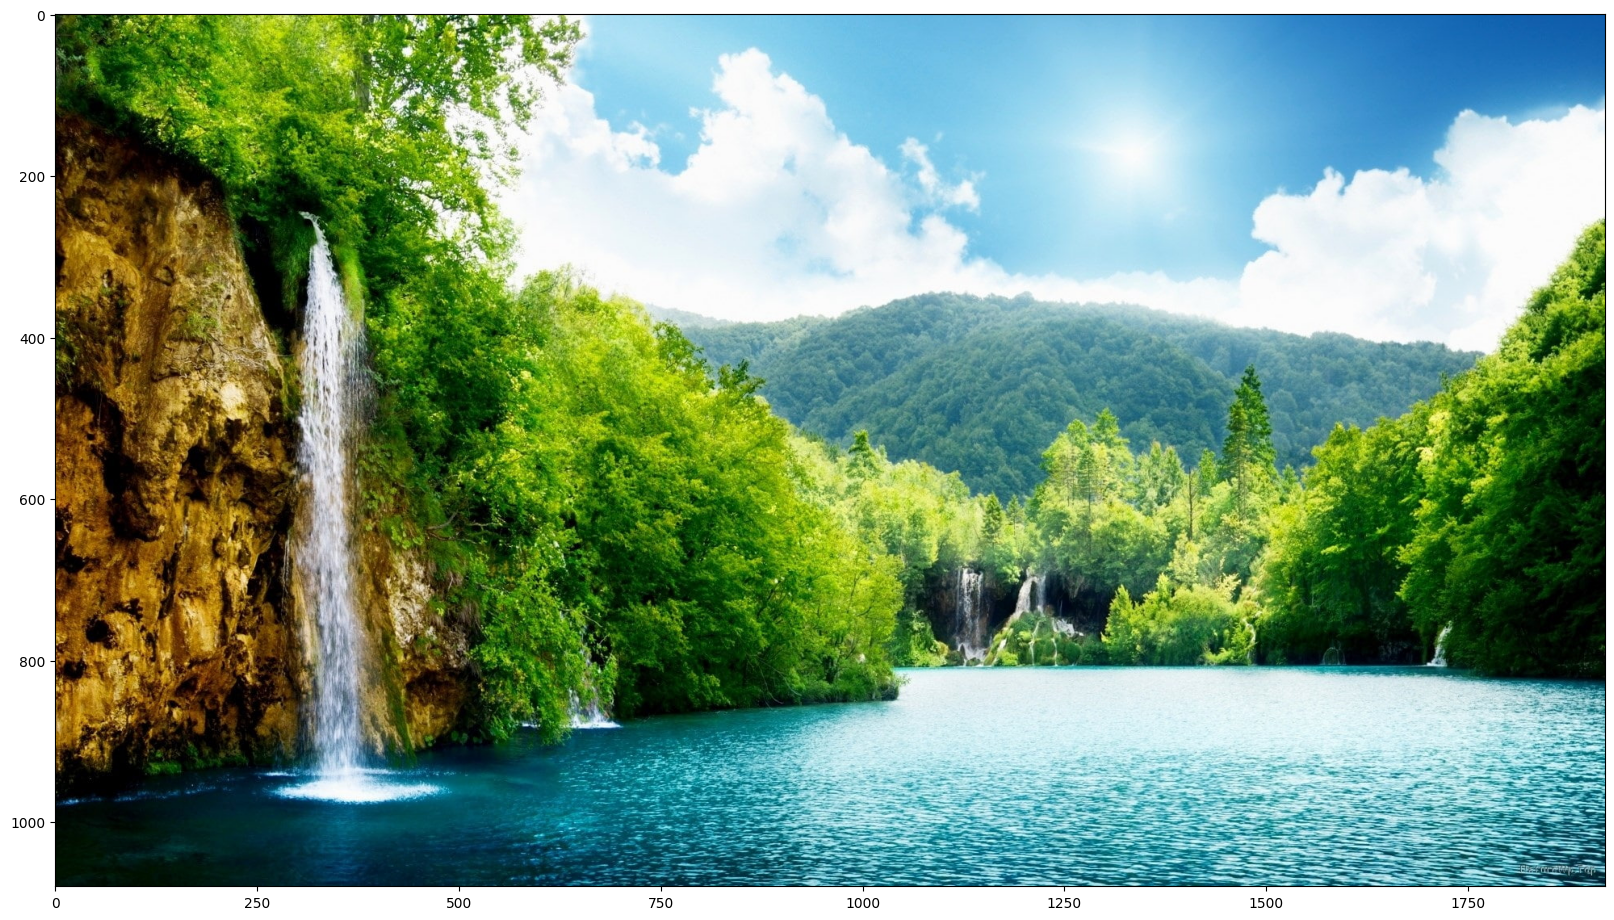

In [ ]:

%pylab inline
import scipy.misc
import imageio
import math
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage import io, transform
from matplotlib import pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore", message="spsolve requires A be CSC or CSR matrix format")
# img = scipy.misc.face()
img = io.imread('/content/sample_data/testingImagePDC.jpg', plugin='matplotlib', as_gray=False)
# img = transform.resize(img, (768,1024 ))
figure(figsize=(20,20))
imshow(img)
w=8 #modify it if you want, maximal 8 due to default quantization table is 8*8
w=max(2,min(8,w))
h=w
xLen = img.shape[1]//w
yLen = img.shape[0]//h
runBits=1 #modify it if you want
bitBits=3  #modify it if you want
rbBits=runBits+bitBits ##(run,bitSize of coefficient)
useYCbCr=True #modify it if you want
useHuffman=True #modify it if you want
quantizationRatio=1 #modify it if you want, quantization table=default quantization table * quantizationRatio

## 1.2 Transfer RGB image to YCbCr Image if you want

True

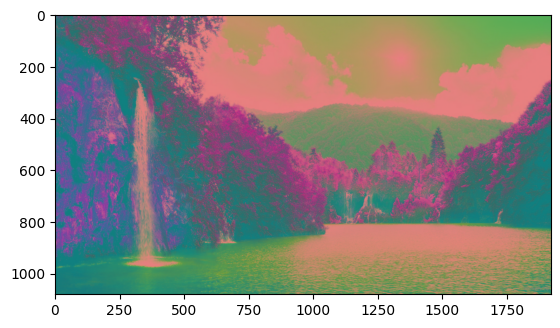

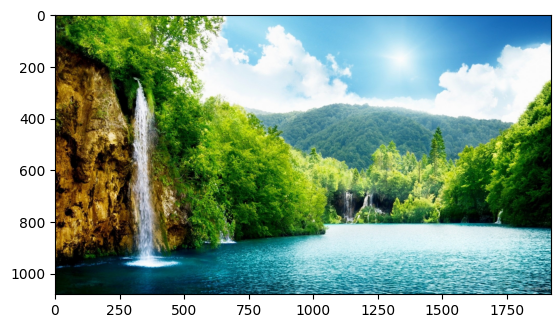

In [ ]:
from skimage.color import rgb2ycbcr,ycbcr2rgb
def myYcbcr2rgb(ycbcr):
  return (ycbcr2rgb(ycbcr).clip(0,1)*255).astype(uint8)
# img = scipy.misc.face()
originalImg=copy(img)
ycbcr=rgb2ycbcr(img)
rgb=myYcbcr2rgb(ycbcr)
imshow(ycbcr.astype(uint8))
figure()
imshow(rgb)
if (useYCbCr):
  img=ycbcr
allclose(rgb,originalImg,atol=1)

# 2.Transform the image into blocks

In [ ]:
def toBlocks(img):
  blocks = zeros((yLen,xLen,h,w,3),dtype=int16)
  for y in range(yLen):
    for x in range(xLen):
      blocks[y][x]=img[y*h:(y+1)*h,x*w:(x+1)*w]
  return array(blocks)
  
blocks = toBlocks(img)

def plotBlocks(blocks,gray=False):
  xLen=blocks.shape[1]
  yLen=blocks.shape[0]
  for y in range(yLen):
    for x in range(xLen):
      subplot(yLen,xLen,1+xLen*y+x)
      imshow(blocks[y][x],cmap=cm.gray if gray else cm.Accent)
      axis('off')
x1=int(0.47*xLen)#x1,x2,y1,y2 is location of the face
y1=int(0.21*yLen)
figure(figsize=(5,5))
if(useYCbCr):
  def ycbcrBlock2rgb(block):
    return (ycbcr2rgb(block)*(255/ycbcr2rgb(block).max())).astype(uint8)
  plotBlocks(array(list(map(ycbcrBlock2rgb,blocks[y1:y1+40,x1:x1+40]))))
else:
  plotBlocks(blocks[y1:y1+40,x1:x1+40])



# 3.DCT (Discrete Cosine Transform)

## 3.1 operate DCT on all the blocks respectively, check the difference between step-2 and step-3

In [ ]:
from scipy.fftpack import dct,idct
def dctOrDedctAllBlocks(blocks,type="dct"):
  f=dct if type=="dct" else idct
  dedctBlocks = zeros((yLen,xLen,h,w,3))
  for y in range(yLen):
    for x in range(xLen):
      d = zeros((h,w,3))
      for i in range(3):
        block=blocks[y][x][:,:,i]
        d[:,:,i]=f(f(block.T, norm = 'ortho').T, norm = 'ortho')
        if (type!="dct"):
          d=d.round().astype(int16)
      dedctBlocks[y][x]=d
  return dedctBlocks
dctBlocks=dctOrDedctAllBlocks(blocks,"dct")
# dctBlocks

## 3.2 transforming the DCT blocks back to image


In [ ]:
def blocks2img(blocks):
  W=xLen*w
  H=yLen*h
  img = zeros((H,W,3))
  for y in range(yLen):
    for x in range(xLen):
      img[y*h:y*h+h,x*w:x*w+w]=blocks[y][x]
  return img
newImg=blocks2img(dctBlocks)
# output is in the form Numpy Array

# 4.Quantized DCT(save approximations, omit details)

4.1 Use default quantization table to quantize all dct blocks

In [ ]:
# #quantization table
# QY=array([[16,11,10,16,24,40,51,61],
#      [12,12,14,19,26,58,60,55],
#      [14,13,16,24,40,57,69,56],
#      [14,17,22,29,51,87,80,62],
#      [18,22,37,56,68,109,103,77],
#      [24,35,55,64,81,104,113,92],
#      [49,64,78,87,103,121,120,101],
#      [72,92,95,98,112,100,103,99]])
# QC=array([[17,18,24,47,99,99,99,99],
#      [18,21,26,66,99,99,99,99],
#      [24,26,56,99,99,99,99,99],
#      [47,66,99,99,99,99,99,99],
#      [99,99,99,99,99,99,99,99],
#      [99,99,99,99,99,99,99,99],
#      [99,99,99,99,99,99,99,99],
#      [99,99,99,99,99,99,99,99]])
# QY=QY[:w,:h]
# QC=QC[:w,:h]
# qDctBlocks=copy(dctBlocks)
# Q3 = moveaxis(array([QY]+[QC]+[QC]),0,2)*quantizationRatio if useYCbCr else dstack([QY*quantizationRatio]*3)#all r-g-b/Y-Cb-Cr 3 channels need to be quantized
# Q3=Q3*((11-w)/3)
# qDctBlocks=(qDctBlocks/Q3).round().astype('int16') 

In [ ]:
#quantization table
import numpy as np

def generate_quantization_table(QF):
    # Create base quantization table
    # LUMINENCE
    base_table = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                           [12, 12, 14, 19, 26, 58, 60, 55],
                           [14, 13, 16, 24, 40, 57, 69, 56],
                           [14, 17, 22, 29, 51, 87, 80, 62],
                           [18, 22, 37, 56, 68, 109, 103, 77],
                           [24, 35, 55, 64, 81, 104, 113, 92],
                           [49, 64, 78, 87, 103, 121, 120, 101],
                           [72, 92, 95, 98, 112, 100, 103, 99]])

    # Calculate scaling factor based on quality factor QF
    if QF < 50:
        scale = 50 / QF
    else:
        scale = 2 - QF / 50

    # Calculate quantization table by scaling the base table
    table = np.round(base_table * scale)

    # Clip table values to range [1, 255]
    table = np.clip(table, 1, 255)

    return table


def generate_quantization_table1(QF):
    # Create base quantization table
    # CHROMINANCE
    base_table = np.array([[17,18,24,47,99,99,99,99],
     [18,21,26,66,99,99,99,99],
     [24,26,56,99,99,99,99,99],
     [47,66,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99]])

    # Calculate scaling factor based on quality factor QF
    if QF < 50:
        scale = 50 / QF
    else:
        scale = 2 - QF / 50

    # Calculate quantization table by scaling the base table
    table = np.round(base_table * scale)

    # Clip table values to range [1, 255]
    table = np.clip(table, 1, 255)

    return table

print("ENTER THE QUALITY FACTOR :");
QF=int(input())
QY=generate_quantization_table(QF)
print("QY\n",QY)
QC=generate_quantization_table1(QF)
print("QC\n",QC)

QY=QY[:w,:h]
QC=QC[:w,:h]
qDctBlocks=copy(dctBlocks)
Q3 = moveaxis(array([QY]+[QC]+[QC]),0,2)*quantizationRatio if useYCbCr else dstack([QY*quantizationRatio]*3)#all r-g-b/Y-Cb-Cr 3 channels need to be quantized
# Q3 IS RESULTANT QUNATIZATION MATRIX
Q3=Q3*((11-w)/3)
qDctBlocks=(qDctBlocks/Q3).round().astype('int16') 

ENTER THE QUALITY FACTOR :
QY
 [[160. 110. 100. 160. 240. 255. 255. 255.]
 [120. 120. 140. 190. 255. 255. 255. 255.]
 [140. 130. 160. 240. 255. 255. 255. 255.]
 [140. 170. 220. 255. 255. 255. 255. 255.]
 [180. 220. 255. 255. 255. 255. 255. 255.]
 [240. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255.]]
QC
 [[170. 180. 240. 255. 255. 255. 255. 255.]
 [180. 210. 255. 255. 255. 255. 255. 255.]
 [240. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255.]]


#5. Further reducing the block, as small as it can be

5.1 Zig-Zag process

In [ ]:
# The zigZag function takes a 2D block array and returns its coefficients in zig-zag order as a 1D array.
# The zigzag order is used to group the coefficients with the same frequency
def zigZag(block):
  lines=[[] for i in range(h+w-1)] 
  for y in range(h): 
    for x in range(w): 
      i=y+x 
      if(i%2 ==0): 
          lines[i].insert(0,block[y][x]) 
      else:  
          lines[i].append(block[y][x]) 
  # print("COEFICIENTS IN ZIG ZAG ORDER")
  return array([coefficient for line in lines for coefficient in line])   
print("2D BLOCK ARRAY")
print(qDctBlocks[0][0][:,:,0])
zigZag(qDctBlocks[0][0][:,:,0])
#  This property allows for efficient compression by removing or quantizing the lower frequency coefficients,
#  which have a smaller impact on the image quality.


2D BLOCK ARRAY
[[2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int16)

## 5.2 Huffman Coding

In [ ]:
!pip install huffman
import huffman
from collections import Counter
def huffmanCounter(zigZagArr):
  rbCount=[]
  run=0
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          rbCount.append('1'*runBits+'0'*bitBits)
        run-=k*runGap
      run=min(run,2**runBits-1) 
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      rbCount.append(format(run<<bitBits|bitSize,'0'+str(rbBits)+'b'))
      run=0
    else:
      run+=1
  rbCount.append("0"*(rbBits))
  return Counter(rbCount)
rbCount=zeros(3,dtype=Counter)
rbCount[0]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,0]))
rbCount[1]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,1]))
rbCount[2]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,2]))
rbCount=sum(rbCount)
print("(run,bit) counter for Huffman Coding:\n"+str(rbCount))
print("Huffman Coding:\n"+str(huffman.codebook(rbCount.items())))
# shows how many times each (run,bit) pair occurs in the image block

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
(run,bit) counter for Huffman Coding:
Counter({'0000': 3})
Huffman Coding:
{'0000': ''}


In [ ]:
# The run-length code is a way to represent the zigzag-ordered DCT coefficients in a more efficient
#  way than storing them all as separate values.

In [ ]:
#Show run-length in a readable way
#  run is the number of consecutive zero coefficients that came before the non-zero coefficient,
# size is the number of bits needed to represent the absolute value of the coefficient.
def runLengthReadable(zigZagArr,lastDC):
  rlc=[]
  run=0
  newDC=min(zigZagArr[0],2**(2**bitBits-1)-1)
  DC=newDC-lastDC
  bitSize=max(0,min(int(ceil(log(abs(DC)+0.000000001)/log(2))),2**bitBits-1))
  rlc.append([array(bitSize),DC])
  code=format(bitSize, '0'+str(bitBits)+'b')+"\n"
  if (bitSize>0):
    code=code[:-1]+","+(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))+"\n"
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          code+='1'*runBits+'0'*bitBits+'\n'
          rlc.append([runGap-1,0])
        run-=k*runGap
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      #VLI encoding (next 2 lines of codes)
      code+=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')+','
      code+=(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))+"\n"
      rs=zeros(1,dtype=object)
      rs[0]=array([run,bitSize])
      rs= append(rs,AC)
      rlc.append(rs)
      run=0
    else:
      run+=1
  rlc.append([0,0])
  code+="0"*(rbBits)#end
  return array(rlc),code,newDC
b=zeros(64,dtype=int16)
b[0]=222
b[4]=9
b[11]=33
b[12]=25
b[14]=-129
b[17]=77
b[27]=12
b[47]=82
print(b)
arr,code,DC=runLengthReadable(b,0)
print("DC of this block is: "+str(DC)+" (maximal=2^(2^bitBits)/2)")
print("Defualt:Run and bitSize both occupies 4 bits, so need a byte in total to store them\nColumns: run(0s-gap)|bits needed for coefficient|coefficient")
# print(arr)
print("Run-Length code(using VLI):\n"+str(code))


[ 222    0    0    0    9    0    0    0    0    0    0   33   25    0
 -129    0    0   77    0    0    0    0    0    0    0    0    0   12
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   82    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
DC of this block is: 127 (maximal=2^(2^bitBits)/2)
Defualt:Run and bitSize both occupies 4 bits, so need a byte in total to store them
Columns: run(0s-gap)|bits needed for coefficient|coefficient
Run-Length code(using VLI):
111,1111111
1000
1100,1001
1000
1000
1000
0110,100001
0101,11001
1111,0000000
1000
0111,1001101
1000
1000
1000
1000
1100,1100
1000
1000
1000
1000
1000
1000
1000
1000
1000
1111,1010010
0000


In [ ]:
def runLength(zigZagArr,lastDC,hfm=None):
  rlc=[]
  run=0
  newDC=min(zigZagArr[0],2**(2**bitBits-1))
  DC=newDC-lastDC
  bitSize=max(0,min(int(ceil(log(abs(DC)+0.000000001)/log(2))),2**bitBits-1))
  code=format(bitSize, '0'+str(bitBits)+'b')
  if (bitSize>0):
   code+=(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          code+=('1'*runBits+'0'*bitBits)if hfm == None else  hfm['1'*runBits+'0'*bitBits]#end
        run-=k*runGap
      run=min(run,2**runBits-1) 
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      rb=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b') if hfm == None else hfm[format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')]
      code+=rb+(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))
      run=0
    else:
      run+=1
  code+="0"*(rbBits) if hfm == None else  hfm["0"*(rbBits)]#end
  return code,newDC
code1,DC=runLength(zigZag(qDctBlocks[0][0][:,:,0]),0)
code2,DC=runLength(zigZag(qDctBlocks[0][0][:,:,1]),DC)
code3,DC=runLength(zigZag(qDctBlocks[0][0][:,:,2]),DC)
codeBlock=code1+code2+code3
print(codeBlock+"\nCompresion size of this block: "+str(len(codeBlock)/8)+"KB\nOriginal size of one block: "+str(w*h*3)+"KB")

01010000001110000000000000
Compresion size of this block: 3.25KB
Original size of one block: 192KB


## 5.4 Save the result of Run-Length to bytes

In [ ]:
 def runLength2bytes(code):
  return bytes([len(code)%8]+[int(code[i:i+8],2) for i in range(0, len(code), 8)])
code2bytes=runLength2bytes(codeBlock)
bytes2code="".join([format(i,'08b') for i in list(code2bytes)])
print(bytes2code)

0000001001010000001110000000000000000000


#6.Saving as jpeg

In [ ]:
def huffmanCounterWholeImg(blocks):
  rbCount=zeros(xLen*yLen*3,dtype=Counter)
  zz=zeros(xLen*yLen*3,dtype=object)
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        zz[y*xLen*3+x*3+i]=zigZag(blocks[y, x,:,:,i])
        rbCount[y*xLen*3+x*3+i]=huffmanCounter(zz[y*xLen*3+x*3+i])
  return sum(rbCount),zz
rbCount,zz=huffmanCounterWholeImg(qDctBlocks)
hfm=huffman.codebook(rbCount.items())
sortedHfm=[[hfm[i[0]],i[0],rbCount[i[0]]] for i in rbCount.most_common()]
sortedHfm

[['1', '0000', 97200],
 ['00', '0001', 18050],
 ['011', '1000', 15212],
 ['0101', '1001', 9597],
 ['01001', '0010', 1484],
 ['010001', '1010', 704],
 ['0100001', '0011', 18],
 ['0100000', '1011', 9]]

In [ ]:
print("(run,bit) occupies: "+str(sum(array(rbCount.most_common(),dtype=int32)[:,1]*rbBits)/8/2**10)+"KB")
print("(run,bit) after Huffman Coding occupies: "+str(sum([rbCount[k]*len(v) for k,v in hfm.items()])/8/2**10)+"KB")

(run,bit) occupies: 69.4697265625KB
(run,bit) after Huffman Coding occupies: 27.9732666015625KB


PSNR: 22.65 dB
SSIM: 0.61
0101010111001000101001011011000100111001110100110011100111010011001110011101101101010101011100010100......
b'\x05U\xc8\xa5\xb19\xd39\xd39\xdbUqMQI\xaa)\xaa)'......
Image original size:    5.933 MB
Compression image size: 0.086 MB
Compression ratio:      68.97 : 1


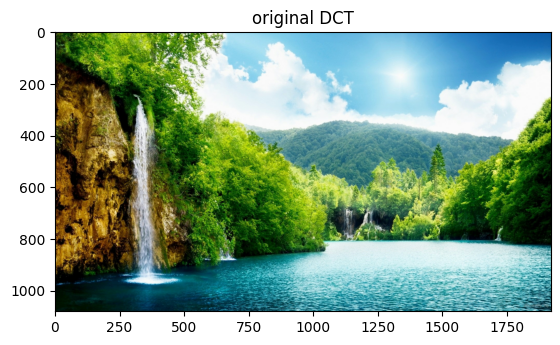

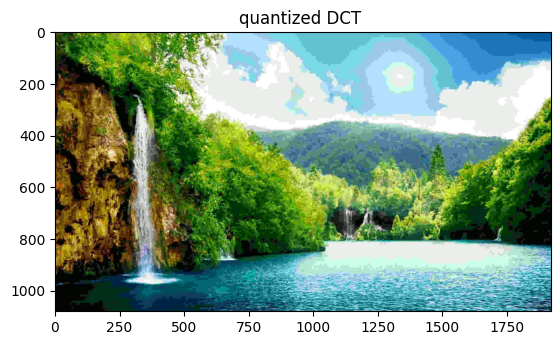

In [ ]:
def savingQuantizedDctBlocks(blocks):
  rbCount,zigZag=huffmanCounterWholeImg(blocks)
  hfm=huffman.codebook(rbCount.items())
  sortedHfm=[[hfm[i[0]],i[0]] for i in rbCount.most_common()]
  code=""
  DC=0
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        codeNew,DC=runLength(zigZag[y*xLen*3+x*3+i],DC,hfm if useHuffman else None)
        code+=codeNew
  savedImg=runLength2bytes(code)
  print(str(code[:100])+"......")
  print(str(savedImg[:20])+"......")
  print("Image original size:    %.3f MB"%(img.size/(2**20)))
  print("Compression image size: %.3f MB"%(len(savedImg)/2**20))
  print("Compression ratio:      %.2f : 1"%(img.size/2*20/(len(savedImg)/2*20)))
  return bytes([int(format(xLen,'012b')[:8],2),int(format(xLen,'012b')[8:]+format(yLen,'012b')[:4],2),int(format(yLen,'012b')[4:],2)])+savedImg,sortedHfm
qr=1
qDctBlocks5=copy(dctBlocks)
Q3_5 = Q3*qr
qDctBlocks5=(qDctBlocks5/Q3_5).round().astype('int16')







# title("quantized DCT (quantization ratio = "+str(qr)+")")
dedctBlocks=dctOrDedctAllBlocks(qDctBlocks5*Q3_5,"idct")
img = imageio.v2.imread("/content/sample_data/testingImagePDC.jpg")
if useYCbCr:
    output=myYcbcr2rgb(blocks2img(dedctBlocks))
else:
     output=blocks2img(dedctBlocks).astype(int16)



psnr_value = psnr(img, output, data_range=255)

# calculate SSIM
ssim_value = ssim(img, output, channel_axis=-1, data_range=255)

# print results
print("PSNR: {:.2f} dB".format(psnr_value))
print("SSIM: {:.2f}".format(ssim_value))

figure()
title("original DCT")
dedctBlocks=dctOrDedctAllBlocks(dctBlocks,"idct")
imshow(myYcbcr2rgb(blocks2img(dedctBlocks)) if useYCbCr else blocks2img(dedctBlocks).astype(int16))
figure()
title("quantized DCT ")
imageio.v3.imwrite('/content/sample_data/CompressedImage.jpg', output)
imshow(output)
# imshow(myYcbcr2rgb(blocks2img(dedctBlocks)) if useYCbCr else blocks2img(dedctBlocks).astype(int16))
savedImg1,rbCount1=savingQuantizedDctBlocks(qDctBlocks5)